In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/"

Mounted at /content/drive


In [2]:
# import packages

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from math import ceil
from IPython.display import display
from PIL import Image
import numpy as np
import tensorflow as tf

In [3]:
# load data with shuffle and non-shuffle flows
# Final train note: adjust file path and batch size as needed

batch_size = 32

# fn for scaling data -1 to 1 while still using ImageDataGenerator

def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

data = ImageDataGenerator(preprocessing_function=prep_fn,
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=45, 
                          validation_split=0.2)

training_data = data.flow_from_directory('/content/drive/My Drive/archive/images/Images', 
                                         target_size=(224, 224), shuffle=True, batch_size = batch_size, 
                                         class_mode='categorical', subset='training')

training_data_noshuffle = data.flow_from_directory('/content/drive/My Drive/archive/images/Images', 
                                         target_size=(224, 224), shuffle=False, batch_size = batch_size, 
                                         class_mode='categorical', subset='training')

test_data = data.flow_from_directory('/content/drive/My Drive/archive/images/Images', 
                                     target_size=(224, 224), batch_size = batch_size, shuffle=False,
                                     class_mode='categorical', subset='validation')

numClasses = 120

Found 16604 images belonging to 120 classes.
Found 16604 images belonging to 120 classes.
Found 4096 images belonging to 120 classes.


In [4]:
import time
start_time = time.time()

In [5]:
# model architecture

cnn = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
cnn.trainable = False

flatten_layer = tf.keras.layers.Flatten()
dense_layer_1 = Dense(1024, activation='relu')
dense_layer_2 = Dense(786, activation='relu')
dense_layer_3 = Dense(345, activation='relu')
prediction_layer = Dense(120, activation='softmax')

Classifier = Sequential([
    cnn,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
])

94668760/94668760 [==============================] - 5s 0us/step


In [9]:
# compile and train
# Final train note: adjust MyEpochs to match homebrew CNNs, can adjust batch size as well if needed

MyEpochs = 50
opt = keras.optimizers.Adam()

Classifier.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt, 
              metrics=['accuracy']) 

Classifier.fit(training_data,
                        batch_size = 32,
                        epochs = MyEpochs,
                        validation_data=test_data,
                        shuffle = 1)

Epoch 1/50
519/519 [==============================] - 288s 547ms/step - loss: 0.5872 - accuracy: 0.8938 - val_loss: 3.8778 - val_accuracy: 0.5632
Epoch 2/50
519/519 [==============================] - 284s 547ms/step - loss: 0.6676 - accuracy: 0.8782 - val_loss: 4.0002 - val_accuracy: 0.5347
Epoch 3/50
519/519 [==============================] - 284s 546ms/step - loss: 0.6283 - accuracy: 0.8793 - val_loss: 3.8312 - val_accuracy: 0.5334
Epoch 4/50
519/519 [==============================] - 283s 545ms/step - loss: 0.5676 - accuracy: 0.8879 - val_loss: 4.1728 - val_accuracy: 0.5571
Epoch 5/50
519/519 [==============================] - 282s 544ms/step - loss: 0.6070 - accuracy: 0.8886 - val_loss: 3.7960 - val_accuracy: 0.5537
Epoch 6/50
519/519 [==============================] - 284s 548ms/step - loss: 0.6286 - accuracy: 0.8838 - val_loss: 3.8683 - val_accuracy: 0.5378
Epoch 7/50
519/519 [==============================] - 283s 546ms/step - loss: 0.6236 - accuracy: 0.8820 - val_loss: 3.6900 -

In [10]:
# architecture of layers

Classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 786)               805650    
                                                                 
 dense_2 (Dense)             (None, 345)               271515    
                                                                 
 dense_3 (Dense)             (None, 120)               41520     
                                                                 
Total params: 127,444,957
Trainable params: 103,880,157


In [11]:
# fine tuning
# Final train note: don't adjust any of these hyperparameters, keep as-is

cnn.trainable = True

Classifier.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.categorical_crossentropy,
    metrics=['Accuracy'],
)

MyEpochs = 10
Classifier.fit(training_data,
                        batch_size = 10,
                        epochs = MyEpochs,
                        validation_data=test_data,
                        shuffle = 1)

Classifier.save('ResNet50V2.h5')

Epoch 1/10
519/519 [==============================] - 319s 549ms/step - loss: 2.2355 - Accuracy: 0.6440 - val_loss: 4.3935 - val_Accuracy: 0.4224
Epoch 2/10
519/519 [==============================] - 284s 548ms/step - loss: 1.4035 - Accuracy: 0.7315 - val_loss: 3.9330 - val_Accuracy: 0.4648
Epoch 3/10
519/519 [==============================] - 284s 547ms/step - loss: 1.0511 - Accuracy: 0.7852 - val_loss: 3.7962 - val_Accuracy: 0.4834
Epoch 4/10
519/519 [==============================] - 284s 547ms/step - loss: 0.9312 - Accuracy: 0.8195 - val_loss: 3.6268 - val_Accuracy: 0.4971
Epoch 5/10
519/519 [==============================] - 283s 545ms/step - loss: 0.7713 - Accuracy: 0.8427 - val_loss: 3.6765 - val_Accuracy: 0.5190
Epoch 6/10
519/519 [==============================] - 283s 546ms/step - loss: 0.6766 - Accuracy: 0.8580 - val_loss: 3.6314 - val_Accuracy: 0.5295
Epoch 7/10
519/519 [==============================] - 283s 545ms/step - loss: 0.6241 - Accuracy: 0.8720 - val_loss: 3.6935 -

In [12]:
# model evaluation

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# confusion matrix, accuracy, classification report 

training_data.reset()
test_data.reset()

predicted_scores = Classifier.predict(test_data, verbose=1)
predicted_labels = predicted_scores.argmax(axis=1) 

test_labels = test_data.labels

print(test_labels)
print(predicted_labels)

acc_score = accuracy_score(test_labels, predicted_labels)
CFM = confusion_matrix(test_labels, predicted_labels)

print("\n", "Accuracy: " + str(format(acc_score,'.3f')))
print("\n", "CFM: \n", confusion_matrix(test_labels, predicted_labels))
print("\n", "Classification report: \n", classification_report(test_labels, predicted_labels))

128/128 [==============================] - 57s 436ms/step
[  0   0   0 ... 119 119 119]
[  0   0  21 ...  12 119 119]

 Accuracy: 0.556

 CFM: 
 [[14  0  0 ...  2  0  0]
 [ 0 24  0 ...  0  0  0]
 [ 2  0 35 ...  0  0  0]
 ...
 [ 0  0  0 ... 15  2  0]
 [ 0  0  0 ...  0 23  0]
 [ 0  0  0 ...  0  0 31]]

 Classification report: 
               precision    recall  f1-score   support

           0       0.54      0.47      0.50        30
           1       0.83      0.65      0.73        37
           2       0.62      0.70      0.66        50
           3       0.61      0.48      0.54        29
           4       0.42      0.50      0.46        42
           5       0.78      0.68      0.72        37
           6       0.79      0.67      0.72        39
           7       0.53      0.62      0.57        34
           8       0.41      0.41      0.41        34
           9       0.85      0.74      0.80        47
          10       0.64      0.51      0.57        35
          11       0.56

# Visualizations

In [13]:
# Visual Specific Imports
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    auc, 
    roc_curve,
    roc_auc_score,
)


ROC AUC score: 0.77


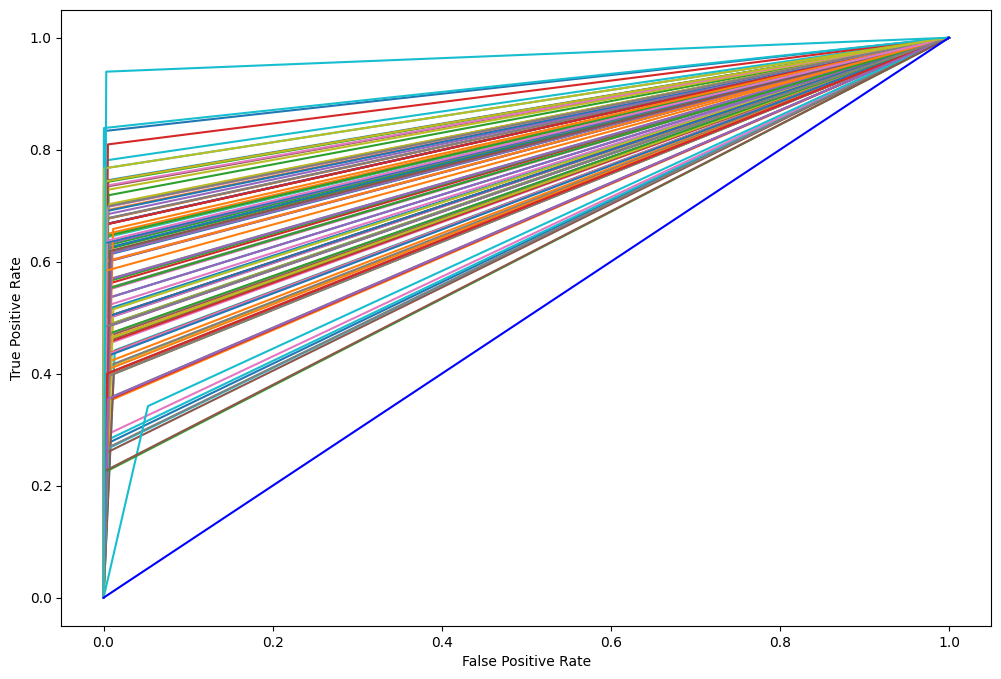

In [14]:
# add visualization here
target = list(test_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    auc_list = []
    auc_results_dict = {}

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        
        auc_list += [auc(fpr, tpr)]

    # Create auc_results_df
    auc_results_dict['Breed'] = target
    auc_results_dict['AUC'] = auc_list
    index = range(len(auc_results_dict['Breed']))
    auc_results_df = pd.DataFrame(auc_results_dict, index=index)

    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')

    return roc_auc_score(y_test, y_pred, average=average), auc_results_df


# Set parameters here
roc_auc_score_result, auc_results_df = multiclass_roc_auc_score(test_labels, predicted_labels)
print('ROC AUC score:', round(roc_auc_score_result,2))

# c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [15]:
classification_report_dict = classification_report(test_labels, predicted_labels, output_dict=True)

macro_avgs = {}
for i in range(3):
    key, value = classification_report_dict.popitem()
    macro_avgs[key] = value

index = range(len(classification_report_dict))
classification_report_df = pd.DataFrame(classification_report_dict).T
classification_report_df.index = classification_report_df.index.astype('int64')

class_results_df = auc_results_df.join(classification_report_df).sort_values('f1-score', ascending=False)

In [16]:
df_macro_avgs = pd.DataFrame(macro_avgs).T.iloc[:2, :3]
print('Averages:')
display(round(df_macro_avgs,2))

Averages:


precision  recall  f1-score
weighted avg       0.61    0.56      0.57
macro avg          0.61    0.55      0.57

Top and Bottom 5 by AUC

In [17]:
print('Top 5 by AUC')
display(class_results_df.sort_values('AUC', ascending=False).head(5))
print('\n\nBottom 5 by AUC')
display(class_results_df.sort_values('AUC', ascending=True).head(5))

Top 5 by AUC


Breed       AUC  precision    recall  \
119          n02116738-African_hunting_dog  0.968097   0.704545  0.939394   
109                     n02112350-keeshond  0.919109   0.928571  0.838710   
30            n02093647-Bedlington_terrier  0.916420   0.937500  0.833333   
103                     n02111129-Leonberg  0.902172   0.618182  0.809524   
59   n02100236-German_short-haired_pointer  0.888656   0.609756  0.781250   

     f1-score  support  
119  0.805195     33.0  
109  0.881356     31.0  
30   0.882353     36.0  
103  0.701031     42.0  
59   0.684932     32.0



Bottom 5 by AUC


Breed       AUC  precision    recall  f1-score  \
112         n02113186-Cardigan  0.611058   0.318182  0.225806  0.264151   
115  n02113799-standard_poodle  0.612411   0.636364  0.225806  0.333333   
95        n02109047-Great_Dane  0.627925   0.470588  0.258065  0.333333   
89       n02107908-Appenzeller  0.630505   0.258065  0.266667  0.262295   
97        n02109961-Eskimo_dog  0.631612   0.363636  0.266667  0.307692   

     support  
112     31.0  
115     31.0  
95      31.0  
89      30.0  
97      30.0

Top and Bottom 5 by F1-Score

In [18]:
print('Top 5 by F1-Score')
display(class_results_df.sort_values('f1-score', ascending=False).head(5))
print('\n\nBottom 5 by F1-Score')
display(class_results_df.sort_values('f1-score', ascending=True).head(5))

Top 5 by F1-Score


Breed       AUC  precision    recall  f1-score  \
30   n02093647-Bedlington_terrier  0.916420   0.937500  0.833333  0.882353   
109            n02112350-keeshond  0.919109   0.928571  0.838710  0.881356   
69       n02102480-Sussex_spaniel  0.883087   0.920000  0.766667  0.836364   
118               n02115913-dhole  0.882964   0.884615  0.766667  0.821429   
65              n02101556-clumber  0.866421   0.916667  0.733333  0.814815   

     support  
30      36.0  
109     31.0  
69      30.0  
118     30.0  
65      30.0



Bottom 5 by F1-Score


Breed       AUC  precision    recall  f1-score  \
99      n02110185-Siberian_husky  0.644808   0.057522  0.342105  0.098485   
20   n02091032-Italian_greyhound  0.635071   0.243902  0.277778  0.259740   
89         n02107908-Appenzeller  0.630505   0.258065  0.266667  0.262295   
75              n02105251-briard  0.693974   0.196721  0.400000  0.263736   
112           n02113186-Cardigan  0.611058   0.318182  0.225806  0.264151   

     support  
99      38.0  
20      36.0  
89      30.0  
75      30.0  
112     31.0

In [19]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 55919.34 seconds
